# Classifying CIFAR10 images using a ResNet and Regularization techniques in PyTorch

Training an image classifier from stratch to over 90% accuracy in less than 5 minutes on a single GPU.

The notebook is an extension to the notebook Image Classification using CNNs in PyTorch, where we trained a deep convolutional neural network to classify images from the CIFAR10 dataset with around 75% accuracy.

# Libraries

In [1]:
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# Preparing the Data

Let us begin by downloading the dataset and creating PyTorch datasets to load the data, just as we did in the previous notebook.

In [2]:
data_dir = './data/cifar10/cifar10'
print(os.listdir(data_dir))

train_dir = os.path.join(data_dir, 'train')

classes = os.listdir(train_dir)
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


There are a few important changes we'll make while creating the PyTorch datasets:

1. Use test set for validation: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set.

This just gives a little more data to train with, in general, once you have picked the best model architecture and hyperparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.

2. Channel-wise data normalization: We will normalize the image tensors by subtracting the mean and dividing the standard deviation across each channel.

As a result, the mean of the data across each channel is 0, and standard deviation is 1.

Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

3. Randomized data augmentations: We wil apply randomly chosen transformations while loading images from the training dataset.

Specially, we will pad each image by 4 pixels, and then take a random crop of size 32x32 pixels, and then flip the image horizontally with a 50% probability.

Since the transformation will be applied randomly and dynamically each time a particular image is loaded, then model sees slightly different images in each epoch of training, which allows it generalize below:

<img src="./images/Data_Augmentation_6e40cf9074.png">

In [3]:
# Data transforms (normalization and data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [4]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches.

We'll use a relatively large batch size of 400 to utilize a larger portion of the GPU RAM.

You can try reducing the batch size and restarting the kernel if you face an "out of memory" error.

In [5]:
batch_size = 400

In [6]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader.

In [7]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


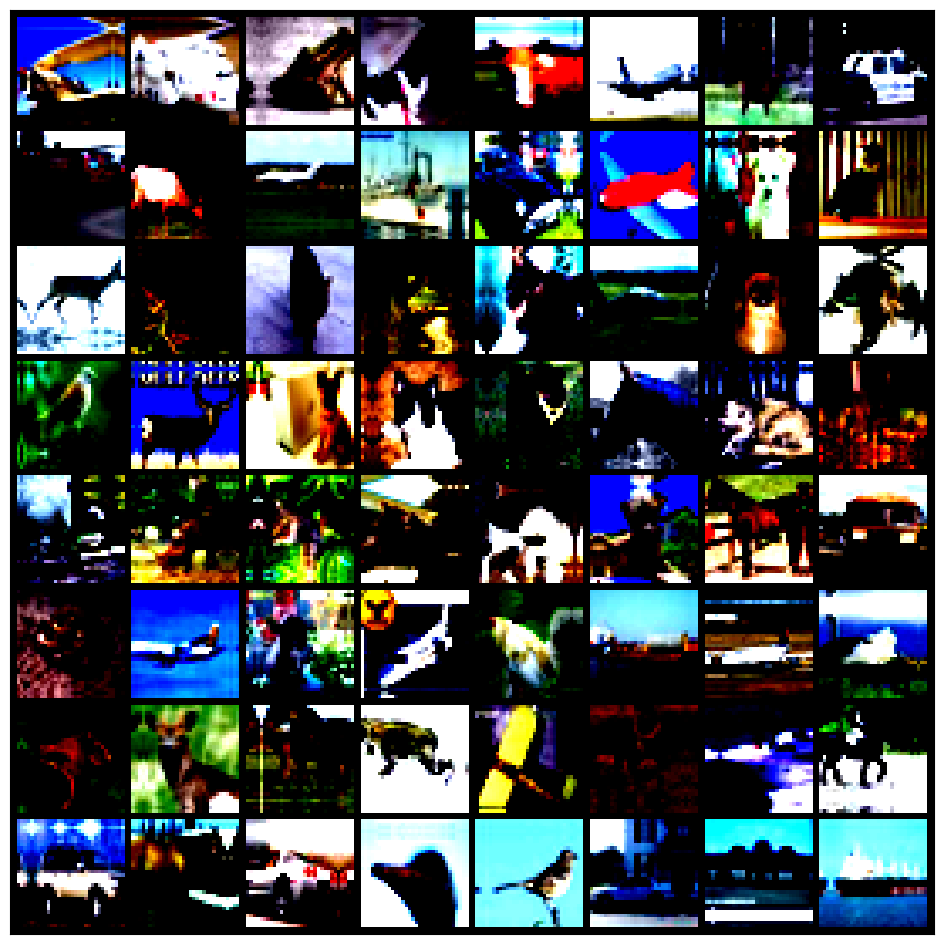

In [8]:
show_batch(train_dl)

The colors seem out of place because of the normalization.

Note that normalization is also applied during inference.

If you look closely, you can see the cropping and reflection padding in some of the images.

Horizontal flip is a bit difficult to detect from visual insepction.

# Using a GPU

To seamlessly use a GPU, if one is avaliable, we define a couple of helper functions (get_default_device and to_device) and a helper class DeviceDataLoader to move our model and data to the GPU as required.

In [9]:
def get_default_device():
    # Pick GPU if avaliable, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    # Move tensor(s) to chosen device
    if isinstance(data, (list, tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        # Yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        # Number of batches
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU(torch.device('cpu')) or a GPU (torch.device('cuda))

In [10]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if avaliable).

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

<img src="./images/ResBlock.png">

In [12]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # RelU can be applied before or after adding the input

In [13]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


### 🧠 What is ReLU?

**ReLU** stands for **Rectified Linear Unit**. It’s a simple function used in neural networks:

```python
ReLU(x) = max(0, x)
```

- If the input is **positive**, it stays the same.
- If the input is **negative**, it becomes **zero**.

🧠 **Why use ReLU?**
- It helps the network learn faster.
- It adds non-linearity, which means the model can learn complex patterns.
- It’s super efficient and avoids some problems like vanishing gradients.

---

### 🧠 What is a Residual Network (ResNet)?

Imagine you're stacking many layers in a deep neural network. Sometimes, the deeper the network gets, the **harder it becomes to train** — it might actually perform worse!

**ResNet solves this by adding a shortcut.**

---

### 🔁 Residual Block (The Shortcut Idea)

Instead of just passing data through layers like this:

```python
output = Layer(x)
```

ResNet does this:

```python
output = Layer(x) + x
```

This is called a **skip connection** or **residual connection**.

🧠 **Why is this helpful?**
- It lets the model “skip” layers if needed.
- It helps preserve the original input and avoid losing important information.
- It makes training deep networks much easier and more accurate.

---

### 🔗 ReLU in ResNet

In a **residual block**, ReLU is used after each convolution layer to activate the features. The typical flow looks like:

```python
x → Conv → ReLU → Conv → Add x → ReLU
```

So ReLU helps the network learn better features, and the **residual connection** helps it avoid forgetting the original input.

---

### 🎯 Simple Analogy

Imagine you're writing a long essay. A residual connection is like keeping the original draft nearby while editing — so if your edits mess things up, you can always refer back to the original. ReLU is like a highlighter that marks the important parts.

This seeming small change produces a drastic improvement in the performance of the model.

Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous year.

<img src="./images/0_-SwM1XOPnrx2OKxN.png">

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images) # Generate Predictions
        loss = F.cross_entropy(out, labels) # Calculate Loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images) # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate Loss
        acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss':loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64) # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [16]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Train the Model

Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

- Learning rate scheduling : Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training.

There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

- Weight decay : We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

- Gradient clipping : Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This is a simple yet effective technique is called gradient clipping.

### 🚀 1. **Learning Rate Scheduling**

**What it is:**  
It’s a way to **adjust the speed** at which your model learns during training.

**Why it matters:**  
If the learning rate is too high, the model jumps around and misses the best solution. If it’s too low, it learns too slowly or gets stuck.

**Simple analogy:**  
Imagine you're hiking down a mountain:
- At the top, you take big steps (high learning rate).
- As you get closer to the bottom, you take smaller steps to avoid falling (lower learning rate).

**How it works:**  
You start with a learning rate like `0.01`, and gradually reduce it using a **schedule** — like every few epochs, or when the model stops improving.

---

### 🏋️ 2. **Weight Decay**

**What it is:**  
It’s a technique to **prevent overfitting** by gently shrinking the model’s weights during training.

**Why it matters:**  
Big weights can make the model memorize the training data too well, which hurts performance on new data.

**Simple analogy:**  
Think of it like packing for a trip — weight decay helps you avoid overpacking by trimming unnecessary stuff.

**How it works:**  
It adds a small penalty to large weights in the loss function, encouraging the model to keep them small and tidy.

---

### ✂️ 3. **Gradient Clipping**

**What it is:**  
It’s a safety measure to **limit how big the updates** to your model can be.

**Why it matters:**  
Sometimes gradients explode (especially in deep or recurrent networks), causing wild updates that break training.

**Simple analogy:**  
Imagine you're steering a car — gradient clipping is like setting a speed limit so you don’t lose control on sharp turns.

**How it works:**  
If the gradient is too large, it’s scaled down to a safe maximum value before updating the weights.

---

### 🧠 Summary Table

| Concept              | Purpose                  | Analogy                        |
|----------------------|--------------------------|--------------------------------|
| Learning Rate Scheduling | Adjust learning speed     | Hiking down a mountain         |
| Weight Decay         | Prevent overfitting       | Trimming excess baggage        |
| Gradient Clipping    | Control unstable updates  | Setting a speed limit          |

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.304704189300537, 'val_acc': 0.0997999981045723}]

We're now ready to train our model.

Instead of SGD (Stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. 

In [34]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [35]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [1], train_loss: 1.3030, val_loss: 1.0957, val_acc: 0.6248
Epoch [2], train_loss: 0.9267, val_loss: 1.8317, val_acc: 0.5320
Epoch [3], train_loss: 0.8778, val_loss: 0.9813, val_acc: 0.6874
Epoch [4], train_loss: 0.6447, val_loss: 0.5617, val_acc: 0.8067
Epoch [5], train_loss: 0.5111, val_loss: 0.7173, val_acc: 0.7719
Epoch [6], train_loss: 0.4256, val_loss: 0.5894, val_acc: 0.8050
Epoch [7], train_loss: 0.3379, val_loss: 0.5010, val_acc: 0.8348
Epoch [8], train_loss: 0.2566, val_loss: 0.3860, val_acc: 0.8738
Epoch [9], train_loss: 0.1842, val_loss: 0.2695, val_acc: 0.9086
Epoch [10], train_loss: 0.1359, val_loss: 0.2576, val_acc: 0.9140


In [36]:
train_time = '4:22'

Our model trained to over 90% accuracy in just 5 minutes!

Try playing around with the data augmentations, network architecture and hyperparameters to achieve the following results:

1. 94% accuracy in under 10 minutes(easy)

2. 90% accuracy in under 2.5 minutes (intermediate)

3. 94% accuracy in under 5 minutes (hard)

Let's us plot the validation set accuracies to study how the model improves over time.

In [37]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

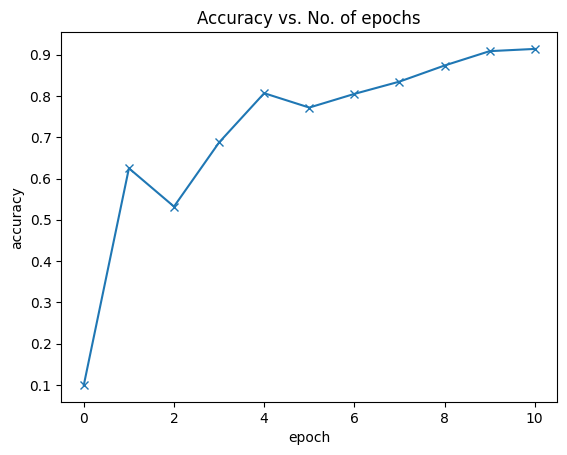

In [38]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [39]:
def plot_losses(history):
    train_losses =[x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

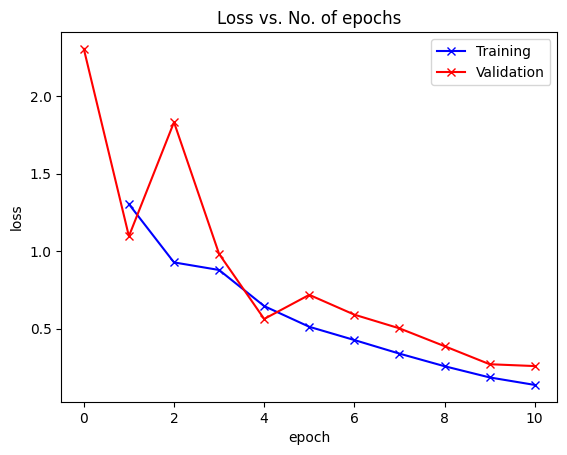

In [40]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet.

Finally, let's visualize how the training rate changed over time, batch-by-batch over all the epochs.

In [41]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

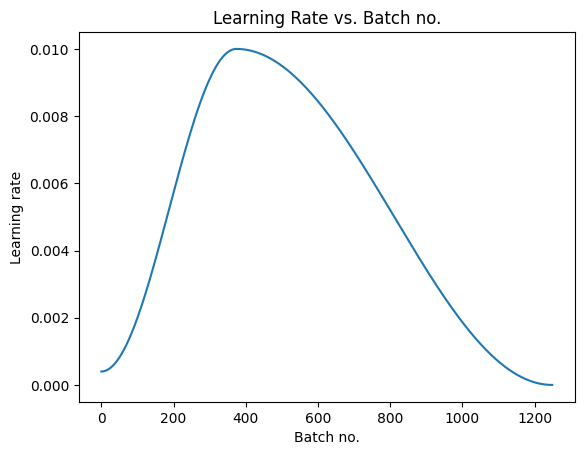

In [42]:
plot_lrs(history)

As expected, the learning rate starts at a lower value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.